In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm  # allows you to output a smart progress bar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import os

# downloading the dataset

In [5]:
root = 'FashionMNIST'

train_data = datasets.FashionMNIST(
    root=root,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root=root,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

60.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

74.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

92.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Extracting FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to FashionMNIST\FashionMNIST\raw



119.3%

Extracting FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to FashionMNIST\FashionMNIST\raw



In [7]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [8]:
test_data.data.shape

torch.Size([10000, 28, 28])

# sample view

In [10]:
label_map = {
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle boot'
}

In [11]:
def view_sample_img(data, index, label_map):
    plt.imshow(data.data[index], cmap='gray')
    plt.title(f'Data Label: {label_map[data.targets[index].item()]}')
    plt.axis('off')
    plt.show()

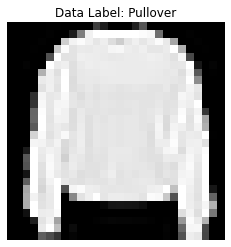

In [16]:
view_sample_img(train_data, index=7, label_map=label_map)

## Creating Dataloader

In [20]:
batch_size = 100

train_data_loader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    )

test_data_loader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=True,
    )

In [22]:
for data, label in test_data_loader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([100, 1, 28, 28])
torch.Size([100])


In [23]:
type(test_data_loader)

torch.utils.data.dataloader.DataLoader

In [24]:
len(test_data_loader)

100

## CNN Architecture

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [39]:
class CNN(nn.Module):
    def __init__(self, in_, out_):
        super(CNN, self).__init__()
        
        self.conv_pool_01 = nn.Sequential(
            nn.Conv2d(in_channels=in_,out_channels=8,kernel_size=5,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_pool_02 = nn.Sequential(
            nn.Conv2d(in_channels=8,out_channels=16,kernel_size=5,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.Flatten = nn.Flatten()
        self.FC_01 = nn.Linear(in_features=16*4*4, out_features=128)
        self.FC_02 = nn.Linear(in_features=128, out_features=64)
        self.FC_03 = nn.Linear(in_features=64, out_features=out_)
    
    def forward(self, x):
        x = self.conv_pool_01(x)
        x = self.conv_pool_02(x)
        x = self.Flatten(x)
        x = self.FC_01(x)
        x = self.FC_02(x)
        x = self.FC_03(x)
        return x

in convolutional 2d NN (this part is comes in ANN/CNN, not covered yet)
- images are 28X28 pixel as input
- h1 = w1 = 28
- input channel = 1
- output channel = 8
- kernal size = 5 (5X5)
- padding = 0

In [4]:
import math
def output_size(input_size, kernal_size, stride, padding):
    '''
    
    Input size = Image pixel size, input height for output height
                 input width for output width
    '''
    result = math.floor(((input_size-kernal_size+2*padding)/stride)+1)
    return result

In [5]:
output_size(16,2,1,0)

15

In [37]:
input_size = 28  # input image pixel height/width
kernal_size = 5
stride = 1  # no of steps
padding = 0
op_size = output_size(input_size,kernal_size,stride,padding)
# for 28X28 pixel size image output size is 24X24
print(op_size)

24


In [40]:
model = CNN(1, 10)
model.to(device)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

## Count No. of trainable parameters

In [50]:
def count_para(model):  
    model_params = {'Modules': [], 'Parameters': []}  # creating dictionary to make pandas df
    total = 0  # initially no. of params 
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:  # if parameter not requires gradiant means it's untrainable
            continue  # so we'll just skip it
        param = parameter.numel()
        model_params['Modules'].append(name)
        model_params['Parameters'].append(param)
        total += param
    df = pd.DataFrame(model_params)
    df = df.style.set_caption(f'Total trainable parameters is: {total}')
    return df

In [51]:
count_para(model)

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


# training loop

In [56]:
learning_rate = 0.001
n_epoch = 10
n_steps = len(train_data_loader)

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(n_epoch):
    with tqdm(train_data_loader) as tqdm_epoch:
# here at this moment we decided to go learn deep learning ANN